# Reannotate the uncertain ones

### Change label of low confidence annotations

In [79]:
# Imports
import scanpy as sc
import celltypist
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [80]:
# Paths
DATA_PATH="/home/felix/projects/facial/felix/data/reprocessed_data/"

In [81]:
datasets = ["C01939B2", "A02989E1", "A02993E1",  "A02994D6",  "A02994E6", "C01939A4",  "C01939A5",  "C01939A6"]
dataset=datasets[1]

In [82]:
print(dataset)
adata = sc.read_h5ad(f"{DATA_PATH}/annotated_stereo/{dataset}_50.h5ad")

A02989E1


In [83]:
adata.obs.loc[adata.obs["conf_score"] < 0.5]

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,leiden_0.25,leiden_0.5,leiden_1,predicted_labels,over_clustering,majority_voting,conf_score
13529146993450,1698,5363.0,116.0,2.162968,1698,5,7,3,mesenchyme B (middle),145,mesenchyme D (young),0.258880
13529146994250,1919,6284.0,117.0,1.861871,1919,5,7,3,epithelia,145,mesenchyme D (young),0.196174
13958643720650,2030,6435.0,131.0,2.035742,2030,5,7,3,mesenchyme B (middle),145,mesenchyme D (young),0.186168
13958643724450,1065,2743.0,65.0,2.369668,1065,5,7,3,myoblasts,48,mesenchyme D (young),0.124285
14388140454600,1216,3288.0,78.0,2.372263,1216,5,7,3,dermal,62,mesenchyme D (young),0.412894
...,...,...,...,...,...,...,...,...,...,...,...,...
61847529070000,312,477.0,18.0,3.773585,312,5,6,4,mesenchyme B (middle),172,epithelia,0.464197
62277025797800,520,961.0,20.0,2.081165,520,5,6,4,myoblasts,7,mesenchyme D (young),0.183916
40372692595050,221,340.0,4.0,1.176471,221,5,6,4,chondrocytes,2,mesenchyme B (middle),0.260973
16320875737700,221,383.0,14.0,3.655352,221,5,6,4,mesenchyme A(near-dermal),2,mesenchyme B (middle),0.322022


In [84]:
adata.obs["labels"] = adata.obs["predicted_labels"].cat.add_categories("Uncertain")
subset = adata.obs.loc[adata.obs["conf_score"] < 0.5]
adata.obs.loc[subset.index, "labels"] = "Uncertain"

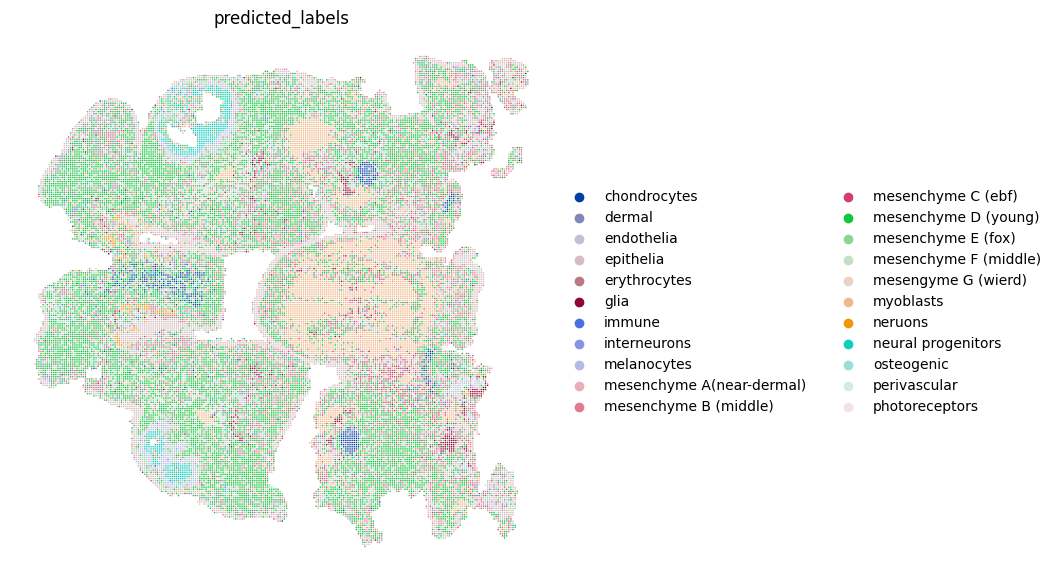

In [85]:
# Set figure size before plotting
plt.rcParams['figure.figsize'] = [7, 7]

adata.obsm['X_spatial'][:, 1] = -adata.obsm['X_spatial'][:, 1] # Flip vertically since that is what my DEG images have.

sc.pl.embedding(adata,
    basis="X_spatial",
    color="predicted_labels",
    frameon=False,
    s=5
)

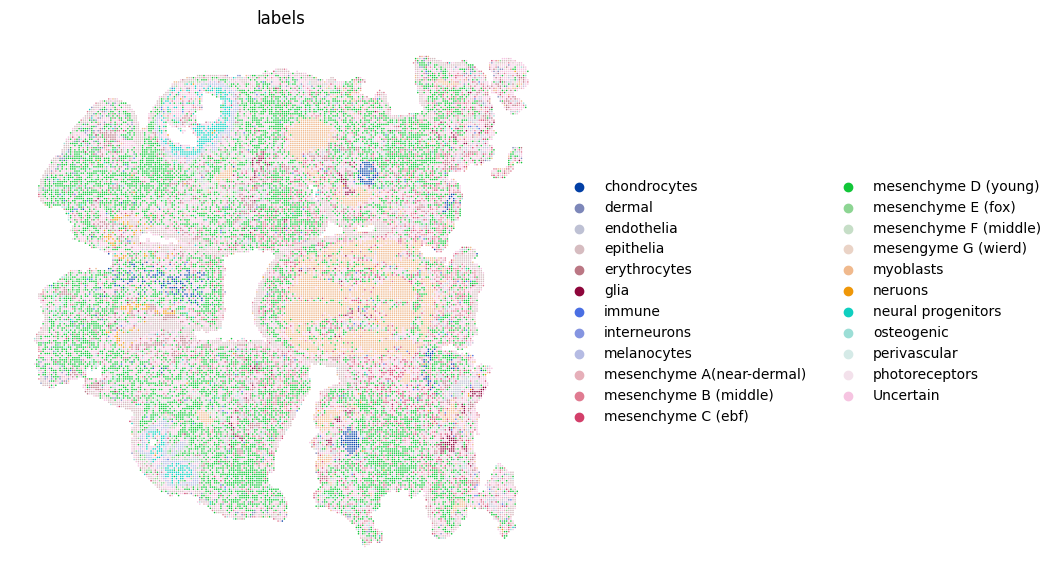

In [86]:
# Set figure size before plotting
plt.rcParams['figure.figsize'] = [7, 7]

sc.pl.embedding(adata,
    basis="X_spatial",
    color="labels",
    frameon=False,
    s=5
)

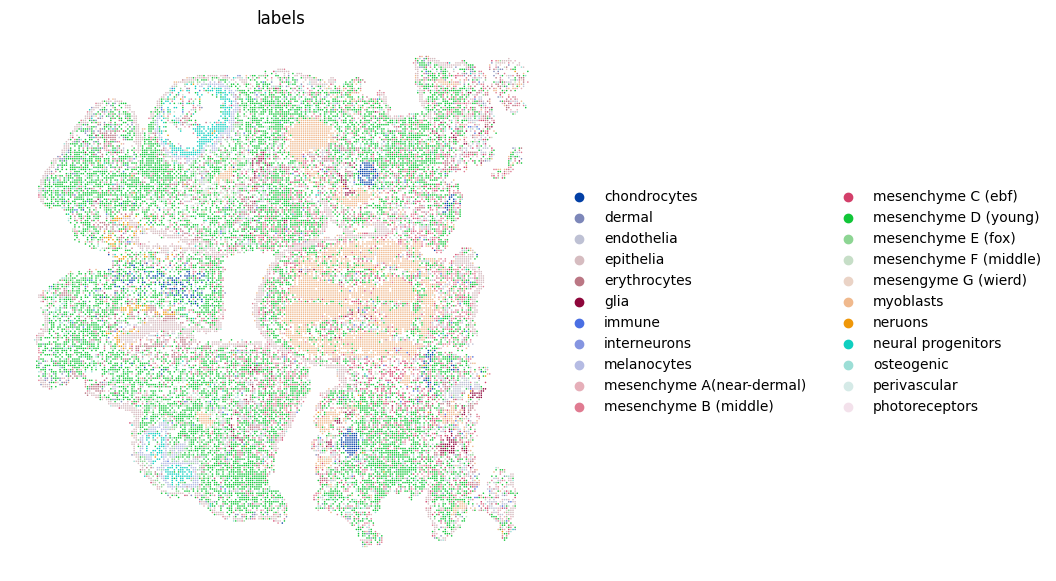

In [87]:
subset=adata[adata.obs["labels"] != "Uncertain"]
# Set figure size before plotting
plt.rcParams['figure.figsize'] = [7, 7]

sc.pl.embedding(subset,
    basis="X_spatial",
    color="labels",
    frameon=False,
    s=5
)

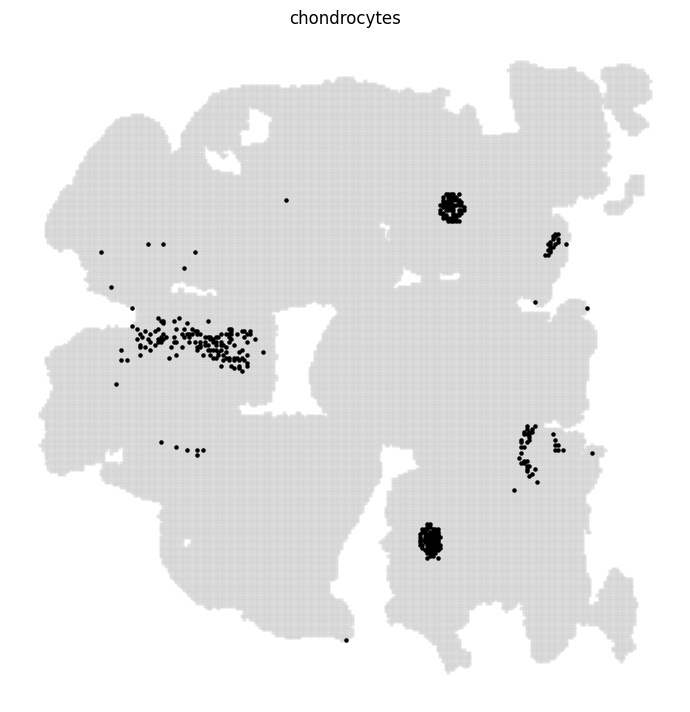

In [88]:
# Set figure size
plt.figure(figsize=(7, 7))

# Choose the cell type of interest
cell_type_of_interest = "chondrocytes"  # replace with your desired cell type

# Get boolean mask for the cells of interest
mask = adata.obs['labels'] == cell_type_of_interest

# Plot background cells (not of interest) in gray
plt.scatter(adata.obsm['X_spatial'][~mask, 0], 
           adata.obsm['X_spatial'][~mask, 1],
           c='lightgray', 
           s=5, 
           alpha=0.5)

# Plot cells of interest in black
plt.scatter(adata.obsm['X_spatial'][mask, 0], 
           adata.obsm['X_spatial'][mask, 1],
           c='black', 
           s=5)

plt.axis('off')
plt.tight_layout()
plt.title(cell_type_of_interest)
plt.show()

## Set threshold
Look at the uncertain ones first where they appear on a UMAP. Look also where they appear in space
. If they appear to be in a reasonable location lower the threshold until they appear in a strange location
. Then set the threshold as such

In [89]:
def plot_spatial_cell_type(adata, cell_type, ax=None, background_color='lightgray', 
                          highlight_color='black', point_size=5, 
                          alpha=0.5, figsize=(7,7)):
    """
    FROM CLAUDE.
    Plot spatial distribution of a specific cell type against background of other cells.
    
    Parameters
    ----------
    adata : AnnData
        Annotated data matrix with spatial coordinates in .obsm['X_spatial']
    cell_type : str
        Cell type to highlight (must match a value in adata.obs['labels'])
    ax : matplotlib.axes.Axes, optional
        Axes to plot on. If None, creates new figure and axes
    background_color : str, optional
        Color for cells not of interest (default: 'lightgray')
    highlight_color : str, optional
        Color for cells of interest (default: 'black')
    point_size : int, optional
        Size of points in scatter plot (default: 5)
    alpha : float, optional
        Transparency of background points (default: 0.5)
    figsize : tuple, optional
        Figure size in inches (default: (7,7)). Only used if ax is None
        
    Returns
    -------
    ax : matplotlib.axes.Axes
        The matplotlib axes containing the plot
    """
    # Create figure and axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    # Get boolean mask for the cells of interest
    mask = adata.obs['labels'] == cell_type
    
    # Plot background cells (not of interest)
    ax.scatter(adata.obsm['X_spatial'][~mask, 0], 
              adata.obsm['X_spatial'][~mask, 1],
              c=background_color, 
              s=point_size, 
              alpha=alpha)
    
    # Plot cells of interest
    ax.scatter(adata.obsm['X_spatial'][mask, 0], 
              adata.obsm['X_spatial'][mask, 1],
              c=highlight_color, 
              s=point_size)
    
    # Customize plot appearance
    ax.set_axis_off()
    ax.set_title(cell_type)
    
    return ax

In [90]:
def re_label(adata, label, threshold):
    """
    """
    if "labels" not in list(adata.obs.columns):
        adata.obs["labels"] = adata.obs["predicted_labels"]
        
    adata.obs["labels"] = adata.obs["labels"].cat.add_categories(f"Uncertain_{label}")
    subset = adata[adata.obs["labels"] == label]
    subset = subset.obs.loc[subset.obs["conf_score"] < threshold]
    adata.obs.loc[subset.index, "labels"] = f"Uncertain_{label}"
    return adata

In [91]:
threshold_dict ={"A02994E6":{
    "perivascular": 0.5, 
     "endothelia": 0.5 , 
     "neruons": 0.4 , 
     "chondrocytes": 0.4 , 
     "osteogenic": 0.5 , 
     "mesenchyme A(near-dermal)": 0.5, 
     "glia": 0.5, 
     "melanocytes": 0.5, 
     "dermal": 0.5, 
     "erythrocytes": 0.5, 
     "epithelia": 0.3, 
     "mesenchyme B (middle)": 0.5, 
     "mesenchyme D (young)": 0.5, 
     "photoreceptors": 0.5, 
     "mesenchyme C (ebf)": 0.5, 
     "interneurons": 0.5, 
     "immune": 0.5,  
     "mesengyme G (wierd)": 0.5,  
     "neural progenitors": 0.3,  
     "mesenchyme F (middle)": 0.5,  
     "mesenchyme E (fox)": 0.5,  
     "myoblasts": 0.5, }, 
                 
                "C01939B2":{
    "perivascular": 0.5, #
     "endothelia": 0.4, 
     "neruons": 0.2, 
     "chondrocytes": 0.2,
     "osteogenic": 0.5,  
     "mesenchyme A(near-dermal)":  0.5, 
     "glia":  0.2, 
     "melanocytes": 0.2,  
     "dermal": 0.3, 
     "erythrocytes": 0.3, 
     "epithelia": 0.1, 
     "mesenchyme B (middle)": 0.5, 
     "mesenchyme D (young)": 0.5, 
     "photoreceptors": 0.5, 
     "mesenchyme C (ebf)": 0.5, 
     "interneurons": 0.5, 
     "immune": 0.5,  
     "mesengyme G (wierd)": 0.5, 
     "neural progenitors": 0.1, 
     "mesenchyme F (middle)": 0.5,  
     "mesenchyme E (fox)":  0.5,  
     "myoblasts": 0.5, }, 
                 
                 "A02989E1":{
    "perivascular": 0.5, 
     "endothelia": 0.2, 
     "neruons": 0.4, 
     "chondrocytes": 0.05,
     "osteogenic": 0.2,
     "mesenchyme A(near-dermal)":  0.5, 
     "glia":  0.2, 
     "melanocytes": 0.1,  
     "dermal": 0.1,
     "erythrocytes": 0.2, 
     "epithelia": 0.2, 
     "mesenchyme B (middle)": 0.5, 
     "mesenchyme D (young)": 0.5, 
     "photoreceptors": 0.5, 
     "mesenchyme C (ebf)": 0.3, 
     "interneurons": 0.5, 
     "immune": 0.5,  
     "mesengyme G (wierd)": 0.5, 
     "neural progenitors": 0.1, 
     "mesenchyme F (middle)": 0.5, 
     "mesenchyme E (fox)":  0.2, 
     "myoblasts": 0.5}, 
                 
                  "A02993E1":{
    "perivascular": 0.5, 
     "endothelia": 0.4, 
     "neruons": 0.5 ,
     "chondrocytes": 0.2, 
     "osteogenic": 0.4, 
     "mesenchyme A(near-dermal)":  0.5, 
     "glia":  0.3, 
     "melanocytes": 0.5,  
     "dermal": 0.4,
     "erythrocytes": 0.4, 
     "epithelia": 0.2, 
     "mesenchyme B (middle)": 0.5,
     "mesenchyme D (young)": 0.5, 
     "photoreceptors": 0.5, 
     "mesenchyme C (ebf)": 0.5, 
     "interneurons": 0.5, 
     "immune": 0.5, 
     "mesengyme G (wierd)": 0.3,  
     "neural progenitors": 0.2,  
     "mesenchyme F (middle)": 0.5,   
     "mesenchyme E (fox)":  0.5, 
     "myoblasts": 0.4}, 
                 
                 "A02994D6":{
    "perivascular": 0.2, 
     "endothelia": 0.5 , 
     "neruons": 0.3 ,
     "chondrocytes": 0.05, 
     "osteogenic": 0.2, 
     "mesenchyme A(near-dermal)":  0.5, 
     "glia":  0.1, 
     "melanocytes": 0.2,  
     "dermal": 0.1, 
     "erythrocytes": 0.2, 
     "epithelia": 0.3, 
     "mesenchyme B (middle)": 0.5,
     "mesenchyme D (young)": 0.5,
     "photoreceptors": 0.5, 
     "mesenchyme C (ebf)": 0.2, 
     "interneurons": 0.5, 
     "immune": 0.4, 
     "mesengyme G (wierd)": 0.2, 
     "neural progenitors": 0.05,
     "mesenchyme F (middle)": 0.5, 
     "mesenchyme E (fox)":  0.3, 
     "myoblasts": 0.2}, 
                 
                  "C01939A4":{
    "perivascular": 0.5, 
     "endothelia": 0.3, 
     "neruons": 0.3 , 
     "chondrocytes": 0.1, 
     "osteogenic": 0.3, 
     "mesenchyme A(near-dermal)":  0.5, 
     "glia":  0.1, 
     "melanocytes": 0.5,  
     "dermal": 0.2, 
     "erythrocytes": 0.2,
     "epithelia": 0.1, 
     "mesenchyme B (middle)": 0.5, 
     "mesenchyme D (young)": 0.5, 
     "photoreceptors": 0.5, 
     "mesenchyme C (ebf)": 0.5, 
     "interneurons": 0.5, 
     "immune": 0.5,  
     "mesengyme G (wierd)": 0.1, 
     "neural progenitors": 0.3, 
     "mesenchyme F (middle)": 0.3,   
     "mesenchyme E (fox)":  0.2, 
     "myoblasts": 0.2}, 
                 
                 "C01939A5":{
    "perivascular": 0.5, 
     "endothelia": 0.5, 
     "neruons": 0.5 , 
     "chondrocytes": 0.2, 
     "osteogenic": 0.3, 
     "mesenchyme A(near-dermal)":  0.5, 
     "glia":  0.5, 
     "melanocytes": 0.5,  
     "dermal": 0.2, 
     "erythrocytes": 0.2, 
     "epithelia": 0.2, 
     "mesenchyme B (middle)": 0.5, 
     "mesenchyme D (young)": 0.5, 
     "photoreceptors": 0.5, 
     "mesenchyme C (ebf)": 0.3, 
     "interneurons": 0.5, 
     "immune": 0.3, 
     "mesengyme G (wierd)": 0.5, 
     "neural progenitors": 0.5,  
     "mesenchyme F (middle)": 0.5,
     "mesenchyme E (fox)":  0.5, 
     "myoblasts": 0.2},
                 
                 "C01939A6":{
    "perivascular": 0.4, 
     "endothelia": 0.5, 
     "neruons": 0.2 , 
     "chondrocytes": 0.2, 
     "osteogenic": 0.3, 
     "mesenchyme A(near-dermal)":  0.5, 
     "glia":  0.1, 
     "melanocytes": 0.3, 
     "dermal": 0.4, 
     "erythrocytes": 0.3, 
     "epithelia": 0.3, 
     "mesenchyme B (middle)": 0.5, 
     "mesenchyme D (young)": 0.5, 
     "photoreceptors": 0.5, 
     "mesenchyme C (ebf)": 0.3, 
     "interneurons": 0.5, 
     "immune": 0.5,  
     "mesengyme G (wierd)": 0.5, 
     "neural progenitors": 0.1, 
     "mesenchyme F (middle)": 0.3,  
     "mesenchyme E (fox)":  0.3, 
     "myoblasts": 0.5},
                }

In [92]:
print(dataset)
adata = sc.read_h5ad(f"{DATA_PATH}/annotated_stereo/{dataset}_50.h5ad")
adata.obsm['X_spatial'][:, 1] = -adata.obsm['X_spatial'][:, 1] # Flip vertically since that is what my DEG images have.

for label in list(set(adata.obs["predicted_labels"])):
    adata = re_label(adata, label, threshold_dict[dataset][label]) 


A02989E1


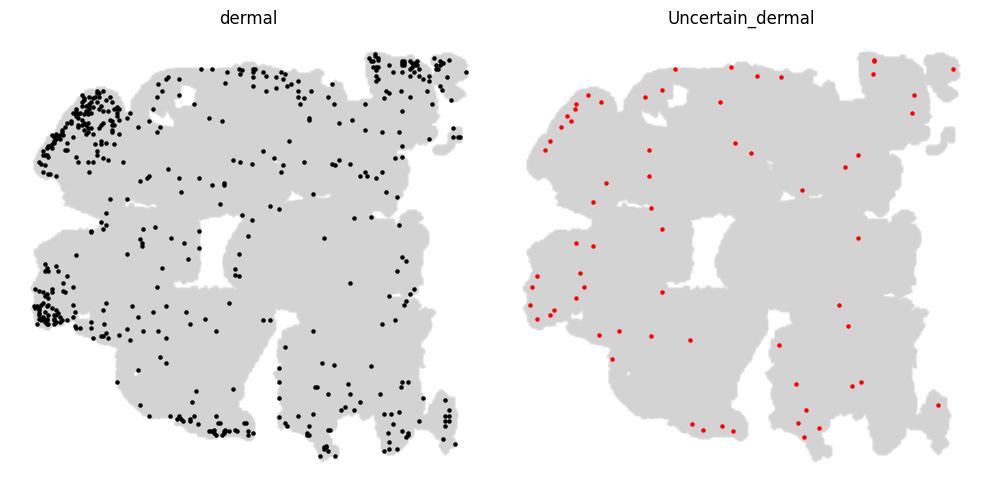

In [93]:
celltype="dermal"
# Create figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot on each subplot
plot_spatial_cell_type(adata, celltype, ax=ax[0])
plot_spatial_cell_type(adata, f"Uncertain_{celltype}", ax=ax[1], highlight_color='red')

# Adjust layout and display
plt.tight_layout()
plt.show()

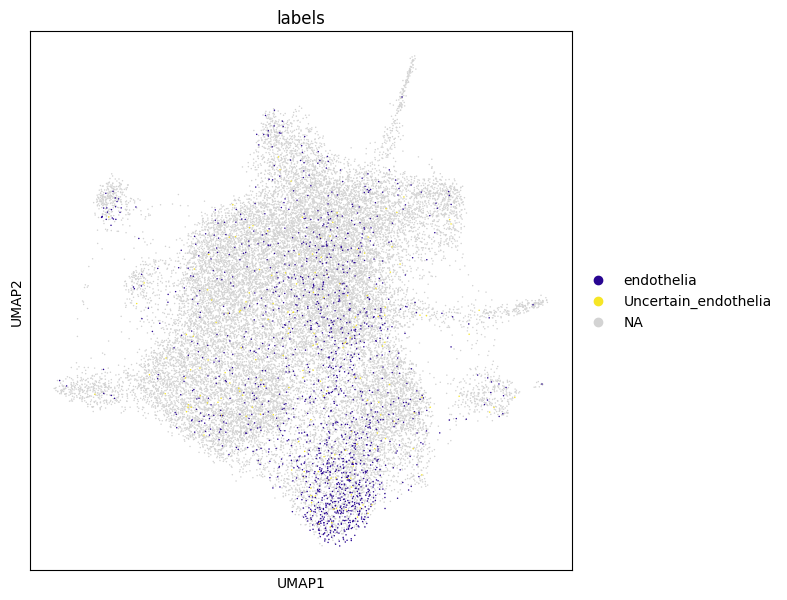

In [36]:
sc.pl.umap(adata, 
           color="labels",
           groups=[celltype, f"Uncertain_{celltype}"],
           palette="plasma")

In [1545]:
# Set all uncertain labels to just uncertain
uncertain_labels = list(set(adata[adata.obs.labels.str.startswith("Uncertain")].obs["labels"]))
adata.obs["labels"] = adata.obs["labels"].cat.add_categories("Uncertain")
subset = adata[adata.obs.labels.str.startswith("Uncertain")]
adata.obs["labels"] = adata.obs["labels"].cat.remove_categories(uncertain_labels)
adata.obs.loc[subset.obs.index, "labels"] = "Uncertain"


In [1546]:
color_dict = {
    'chondrocytes': '#FF0000', 
    'dermal': '#00FF00',  
    'endothelia': '#0000FF', 
    'epithelia': '#000000', 
    'erythrocytes': '#9c3a2c',  
    'glia': '#f6fa00', 
    'immune': '#2f6e30',  
    'interneurons': '#00ffee',  
    'melanocytes': '#ff00d0', 
    'mesenchyme A(near-dermal)': '#4b6e00',  
    'mesenchyme B (middle)': '#015361', 
    'mesenchyme C (ebf)': '#d12888', 
    'mesenchyme D (young)': '#f2a7a7', 
    'mesenchyme E (fox)': '#b4a3ff', 
    'mesenchyme F (middle)': '#adffca',
    'mesengyme G (wierd)': '#ebdada', 
    'myoblasts': '#8b3ef0', 
    'neruons': '#dbfc8d', 
    'neural progenitors': '#ff8400',  
    'osteogenic': '#007862', 
    'perivascular': '#85661d',  
    'photoreceptors': '#5c0000',  
    'Uncertain': '#968d8d', 
}

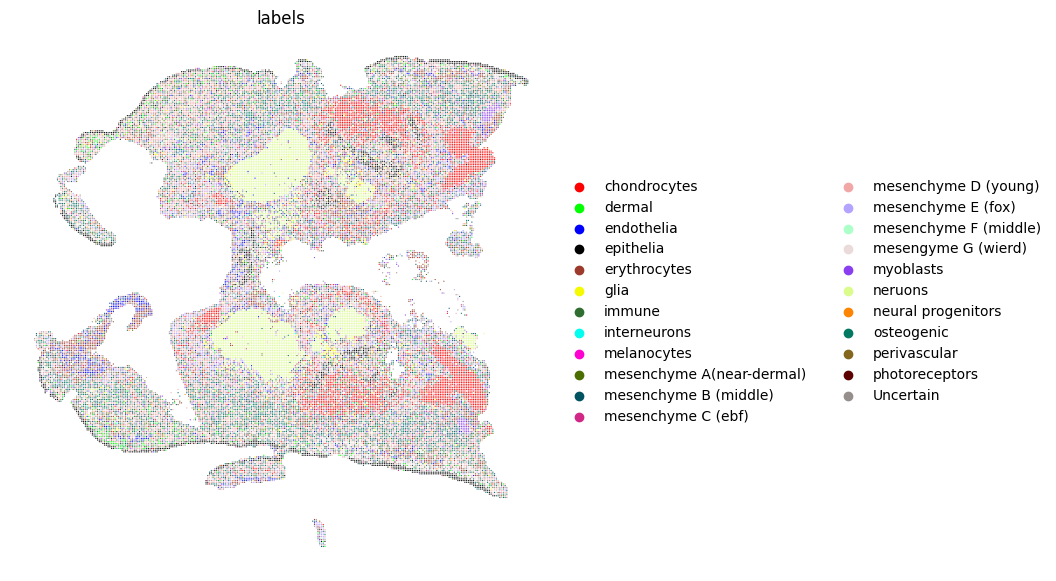

In [1547]:
# Set figure size before plotting
plt.rcParams['figure.figsize'] = [7, 7]
sc.pl.embedding(adata,
    basis="X_spatial",
    color="labels",
    frameon=False,
   # s=5,
    palette=color_dict
)

In [1548]:
not_mesen = adata[~adata.obs.labels.str.startswith("mesen")]
mesen = adata[adata.obs.labels.str.startswith("mesen")]

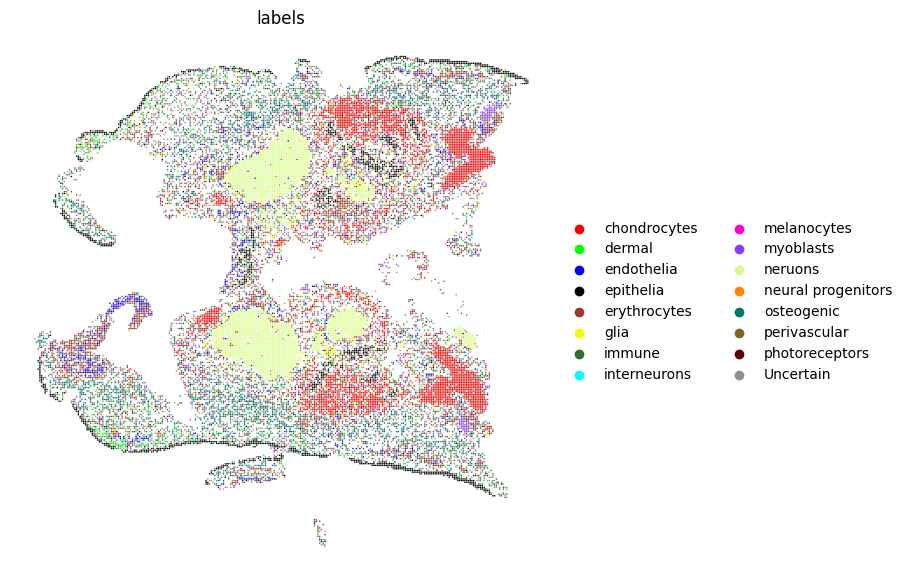

In [1549]:
plt.rcParams['figure.figsize'] = [7, 7]
sc.pl.embedding(not_mesen,
    basis="X_spatial",
    color="labels",
    frameon=False,
 #   s=5,
)

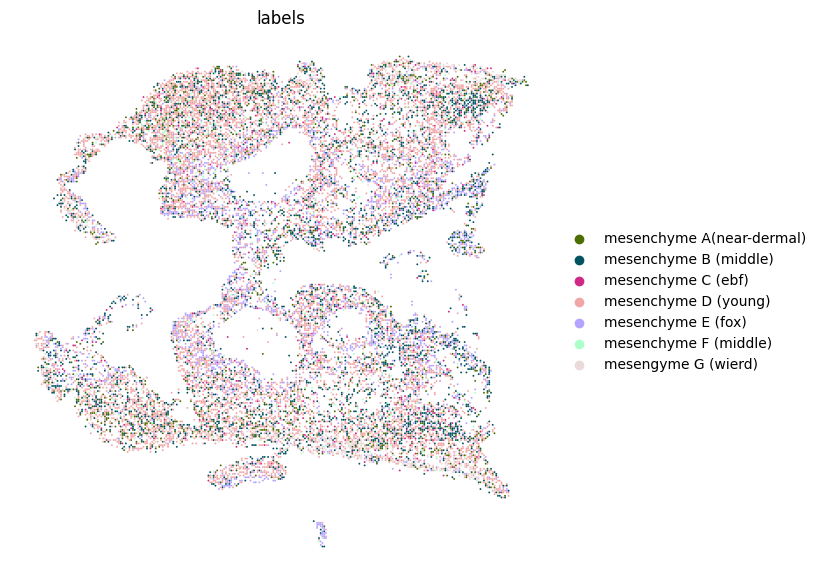

In [1550]:
plt.rcParams['figure.figsize'] = [7, 7]
sc.pl.embedding(mesen,
    basis="X_spatial",
    color="labels",
    frameon=False,
    #s=5,
)

In [1552]:
for dataset in datasets:
    print(dataset)
    adata = sc.read_h5ad(f"{DATA_PATH}/annotated_stereo/{dataset}_50.h5ad")
    adata.obsm['X_spatial'][:, 1] = -adata.obsm['X_spatial'][:, 1] # Flip vertically since that is what my DEG images have.

    for label in list(set(adata.obs["predicted_labels"])):
        adata = re_label(adata, label, threshold_dict[dataset][label]) 
    # Set all uncertain labels to just uncertain
    uncertain_labels = list(set(adata[adata.obs.labels.str.startswith("Uncertain")].obs["labels"]))
    adata.obs["labels"] = adata.obs["labels"].cat.add_categories("Uncertain")
    subset = adata[adata.obs.labels.str.startswith("Uncertain")]
    adata.obs["labels"] = adata.obs["labels"].cat.remove_categories(uncertain_labels)
    adata.obs.loc[subset.obs.index, "labels"] = "Uncertain"

    adata.write_h5ad(f"{DATA_PATH}/annotated_stereo/{dataset}_with_uncertain_50.h5ad")

C01939B2
A02989E1
A02993E1
A02994D6
A02994E6
C01939A4
C01939A5
C01939A6
